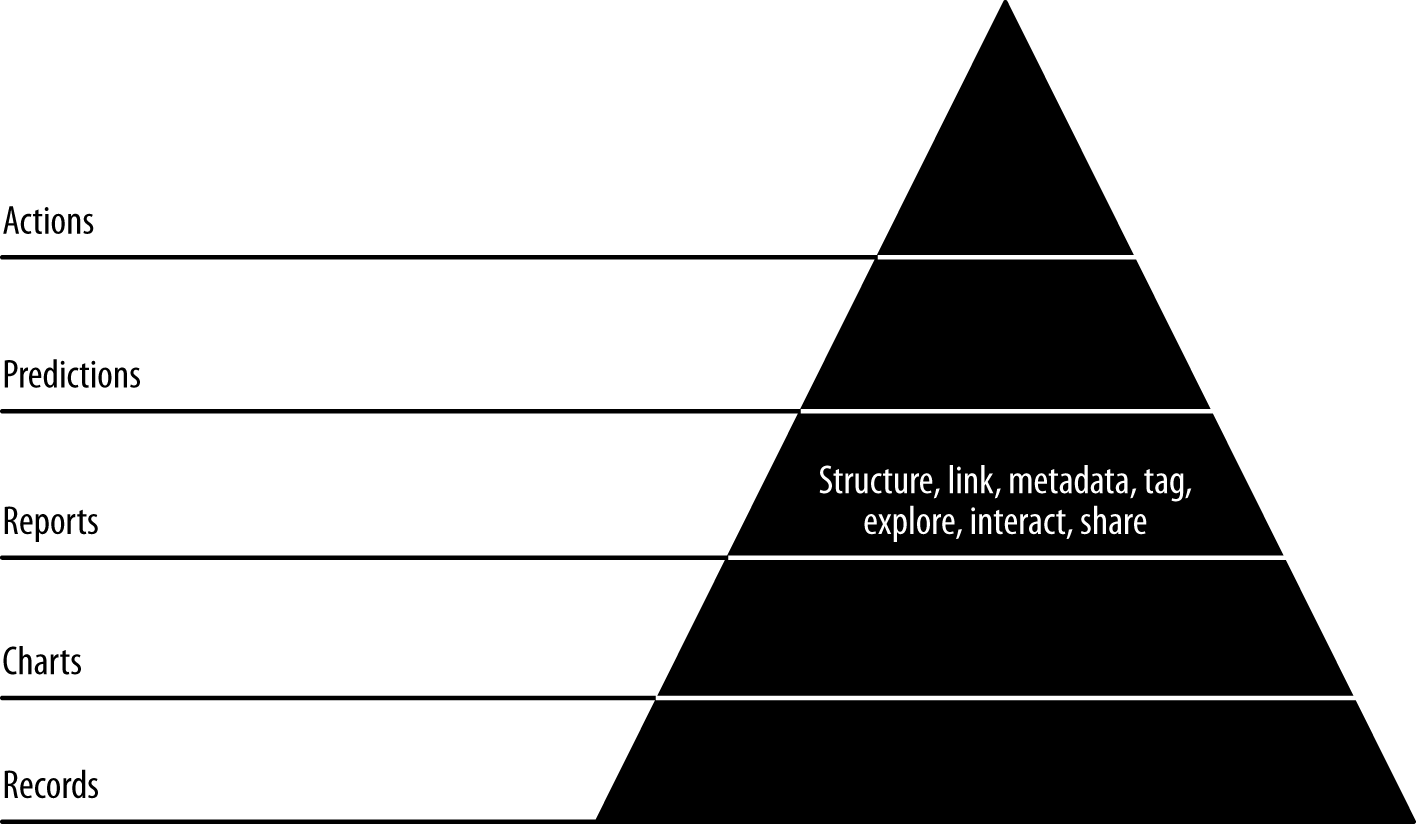

In the next step, our third agile sprint, we’ll extend our chart pages into full-blown reports. In this step, charts become interactive, static pages become dynamic, and our data becomes explorable through networks of linked, related entities with tables and charts. These are the characteristics of the reports stage of the data-value pyramid.

In [ ]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

## Extracting Airlines (Entities)

To build a report, we need to compose multiple views of our dataset. Building these views corresponds with enumerating entities. The entity we created in the previous chapter, airplanes, will serve as a foundation as we increase the number of entities and the corresponding links between them to create reports. As with the last chapter, before we can start creating different views on our data, we need a web page to put our charts and tables into. So let’s create another entity, airlines, and give each a page of its own.

We start by gathering all tail numbers for a given airline in a table on its entity page. Every commercial flight has an airline it operates under, and each airline has a fleet of beautifully branded airplanes that, along with airport facilities and staff, are the key assets of its business. We already created a page for each airplane, so we’ll leverage this data asset to create a list of all tail numbers for each airline.

### Defining Airlines as Groups of Airplanes Using PySpark

We begin by preparing the lists of tail numbers for each airline code, in [ch06/extract_airlines.py](extract_airlines.py). These will form the basis for our airline pages:

In [ ]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers foreach airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_airplane = spark.sql(
  "SELECT DISTINCT Carrier, TailNum FROM on_time_performance"
)

# Now we need to store a sorted list of tail numbers for each carrier, along with a fleet count
airplanes_per_carrier = carrier_airplane.rdd\
  .map(lambda nameTuple: (nameTuple[0], [nameTuple[1]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'Carrier': tuple[0], 
        'TailNumbers': sorted(
          filter(
            lambda x: x != '', tuple[1] # empty string tail numbers were 
                                        # getting through
            )
          ),
        'FleetCount': len(tuple[1])
      }
    )

# Determine the total number of airlines in the dataset
total_airlines = airplanes_per_carrier.count()
print("Total airlines making up US fleet: {}".format(total_airlines))

# Inspect one of our records now that they're prepared to be published in MongoDB
airplanes_per_carrier.first()

#### Storing to MongoDB

Next we'll store this data in the `airplanes_per_carrier` collection.

In [ ]:
# Save to Mongo in the airplanes_per_carrier relation
import pymongo_spark
pymongo_spark.activate()
airplanes_per_carrier.saveToMongoDB(
  'mongodb://localhost:27017/agile_data_science.airplanes_per_carrier'
)

#### Verifying Records in MongoDB

In [4]:
%%bash

mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.count()'
mongo agile_data_science --quiet --eval 'db.airplanes_per_carrier.findOne()'

14
{
	"_id" : ObjectId("57c369bfa68a98e72d30416f"),
	"TailNumbers" : [
		"N281VA",
		"N282VA",
		"N283VA",
		"N284VA",
		"N361VA",
		"N521VA",
		"N522VA",
		"N523VA",
		"N524VA",
		"N525VA",
		"N526VA",
		"N527VA",
		"N528VA",
		"N529VA",
		"N530VA",
		"N621VA",
		"N622VA",
		"N623VA",
		"N624VA",
		"N625VA",
		"N626VA",
		"N627VA",
		"N628VA",
		"N629VA",
		"N630VA",
		"N631VA",
		"N632VA",
		"N633VA",
		"N634VA",
		"N635VA",
		"N636VA",
		"N637VA",
		"N638VA",
		"N639VA",
		"N640VA",
		"N641VA",
		"N642VA",
		"N835VA",
		"N836VA",
		"N837VA",
		"N838VA",
		"N839VA",
		"N840VA",
		"N841VA",
		"N842VA",
		"N843VA",
		"N844VA",
		"N845VA",
		"N846VA",
		"N847VA",
		"N848VA",
		"N849VA",
		"N851VA",
		"N852VA",
		"N853VA",
		"N854VA",
		"N855VA"
	],
	"Carrier" : "VX",
	"FleetCount" : 57
}


### Building an Airline Page in Flask

Next we’ll create a controller for our airline page. Check out [ch06/web/report_flask.py](web/report_flask.py).

#### Airline Page Controller

Our Flask controller is simple. It accepts an airline carrier code and returns a page with a list of airplanes, by tail number, from Mongo:

```python
# Controller: Fetch an airplane entity page
@app.route("/airlines/<carrier_code>")
def airline(carrier_code):
  airline_airplanes = client.agile_data_science.airplanes_per_carrier.find_one(
    {'Carrier': carrier_code}
  )
  return render_template(
    'airlines.html',
    airline_airplanes=airline_airplanes,
    carrier_code=carrier_code
  )
```

#### Airline Page Template

Our template code creates an HTML bullet for each tail number. Check out [ch06/web/templates/airlines.html](web/templates/airlines.html):

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a> / <a href="/airlines/{{carrier_code}}">{{carrier_code}}</a>

  <!-- Summary -->
  <p style="text-align: justify;">{{airline_summary.summary}}</p>
  <h4>Fleet: {{airline_airplanes.FleetCount}} Planes</h4>
  <ul class="nav nav-pills">
    {% for tail_number in airline_airplanes.TailNumbers -%}
    <li class="button">
      <a href="/airplanes/{{tail_number}}">{{tail_number}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

Now in a terminal, change directory to `ch06/web` and run the file `report_flask.py`:

```bash
cd ch06/web
python ./report_flask.py
```

#### Airline Page Result

Now you can visit the resulting web page at [http://localhost:5000/airlines/DL](http://localhost:5000/airlines/DL):

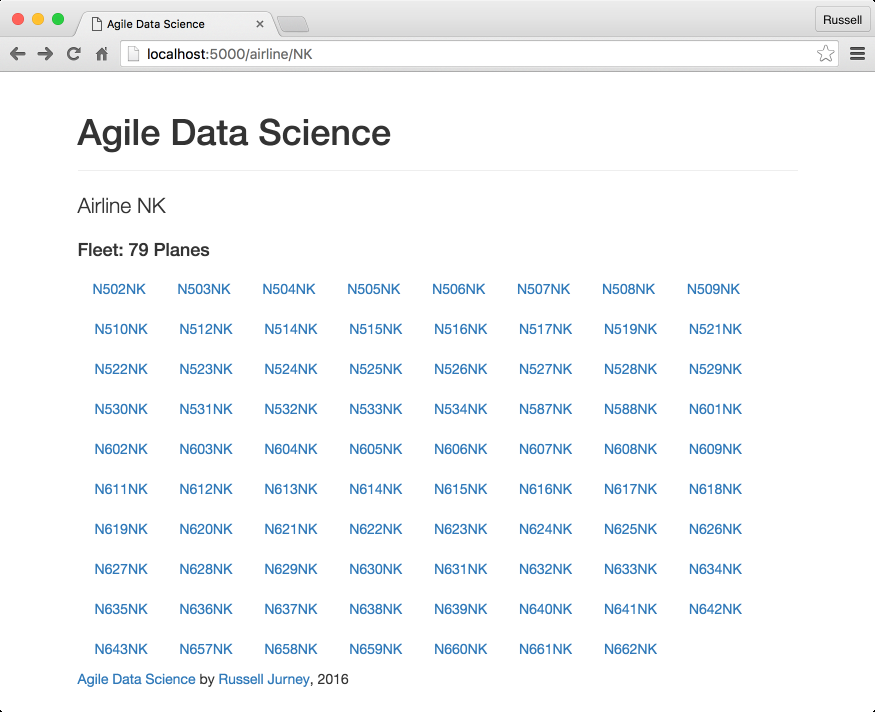

The result is the start of an airline page detailing its entire fleet. Don’t worry, we’ll dress this up later. It is absolutely necessary to ship something ugly before you ship something sharp!

### Linking Back to Our Airline Page

Having created the airline entity page type, we will now link back to it from the airplane page we created, and the search and flight pages in from Chapter 5. We do this by editing the templates for the airplane, flight, and search pages.

We edit [ch06/web/templates/flights_per_airplane.html](web/templates/flights_per_airplane.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights['Flights'] %}
        <tr>
          <td><a href="/airline/{{flight['Carrier']}}">{{flight['Carrier']}}</a></td>
          <td>{{flight['FlightDate']}}</td>
          <td><a href="/on_time_performance?Carrier={{flight['Carrier']}}&FlightDate={{flight['FlightDate']}}&FlightNum={{flight['FlightNum']}}">{{flight['FlightNum']}}</a></td>
          <td>{{flight['Origin']}}</td>
          <td>{{flight['Dest']}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/](http://localhost:5000):

IMAGE

We edit [ch06/web/templates/flight.html](web/templates/flight.html):

```html
    <table class="table">
      <thead>
        <th>Airline</th>
        <th>Origin</th>
        <th>Destination</th>
        <th>Tail Number</th>
        <th>Date</th>
        <th>Air Time</th>
        <th>Distance</th>
      </thead>
      <tbody>
        <tr>
          <td><a href="/airline/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td><a href="/airplane/flights/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/](http://localhost:5000):

IMAGE

And finally we edit [ch06/web/templates/search.html](web/templates/search.html):

```html
    <table class="table table-condensed table-striped">
      ...
      <tbody>
        {% for flight in flights %}
        <tr>
          <td><a href="/airline/{{flight.Carrier}}">{{flight.Carrier}}</a></td>
          <td><a href="/on_time_performance?Carrier={{flight.Carrier}}&FlightDate={{flight.FlightDate}}&FlightNum={{flight.FlightNum}}">{{flight.FlightNum}}</a></td>
          <td>{{flight.Origin}}</td>
          <td>{{flight.Dest}}</td>
          <td>{{flight.FlightDate}}</td>
          <td>{{flight.DepTime}}</td>
          <td><a href="/airplane/{{flight.TailNum}}">{{flight.TailNum}}</a></td>
          <td>{{flight.AirTime}}</td>
          <td>{{flight.Distance}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
```

Now checkout [http://localhost:5000/](http://localhost:5000):

IMAGE

## Creating an All Airlines Home Page

But who knows airline carrier codes (okay, other than me)? We need a way to get users started browsing, so let’s create a home page listing all the airlines operating in the US.

Our controller is simple, just six lines of code. We’re able to reuse the airlines_per_carrier MongoDB collection, this time ignoring the tail numbers and only querying the carrier codes using a find. Let’s also direct users to this page by default, as our index.html for this application:

```python
# Controller: Fetch an airplane entity page
@app.route("/")
@app.route("/airlines")
@app.route("/airlines/")
def airlines():
  airlines = client.agile_data_science.airplanes_per_carrier.find()
  return render_template('all_airlines.html', airlines=airlines)
```

Our template is similar to the one for an individual airline:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/airlines">Airlines</a>

  <p class="lead">US Domestic Airlines</p>
  <ul class="nav nav-pills">
    {% for airline in airlines -%}
    <li class="button">
      <a href="/airline/{{airline.Carrier}}">{{airline.Carrier}}</a>
    </li>
    {% endfor -%}
  </ul>
{% endblock %}
```

The result is a simple but effective way to get users browsing the world of aviation. Check out [http://localhost:5000/](http://localhost:5000):

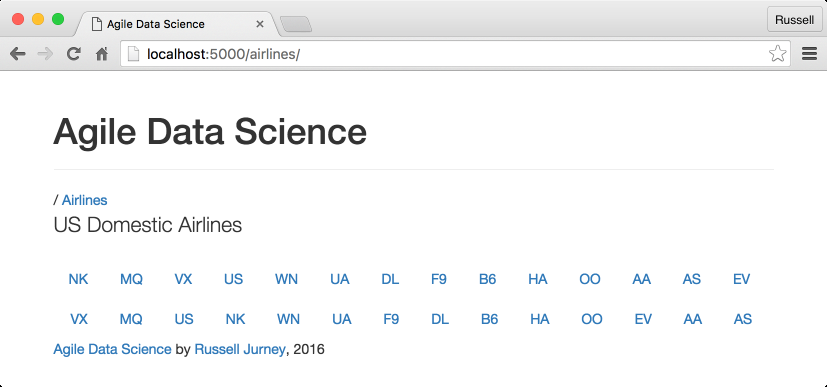



## Curating Ontologies of Semi-structured Data

We can now explore airlines, airplanes, and flights endlessly! Big deal, right? Maybe not, but it is a good start. Let’s extend this by making airplanes and airlines clickable in our flight pages.

Now we can look at airplanes and airlines, their properties, and their relationships as we view flights. This kind of pivot offers insight, and is a form of simple recommendation.

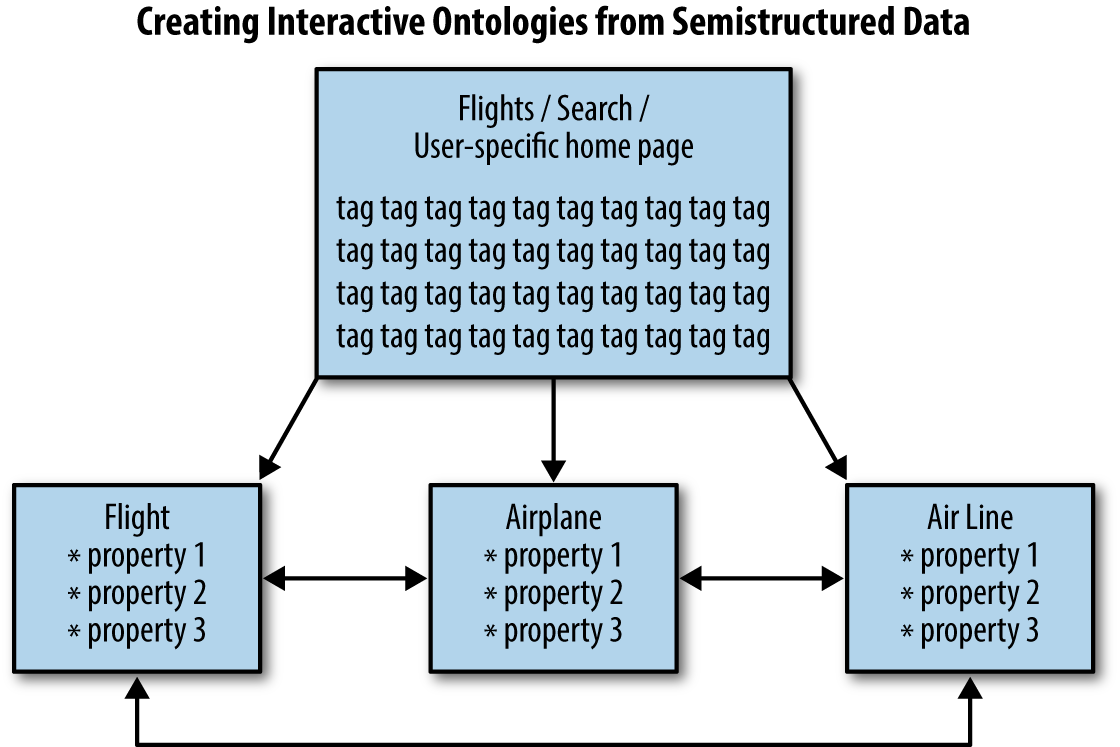

What we’re doing can be described as creating interactive ontologies of semi-structured data. Breaking up our process around building this kind of structure does several things for us. First, it creates small batches of work—one per entity—that break efficiently into agile sprints. This enables a kind of data agility, and also extends our application into a more and more browsable state. This in turn enables users to click around and explore our dataset, which connects the team into the ground truth or reality of the data—which, as you know by now, is a theme in Agile Data Science.

## Improving Airlines

Now that we’ve got airline pages, let’s improve them with some multimedia content: text and images. To begin, let’s get a list of the carrier codes in our primary dataset:

In [1]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# The first step is easily expressed as SQL: get all unique tail numbers 
# for each airline
on_time_dataframe.registerTempTable("on_time_performance")
carrier_codes = spark.sql(
  "SELECT DISTINCT Carrier FROM on_time_performance"
)
carrier_codes.collect()

NameError: name 'spark' is not defined

### Adding Names to Carrier Codes

In order to link more data to our carriers, we need to get the name of each along with the carrier code. This data is available in the airlines database we downloaded from OpenFlights in Chapter 5. Let’s inspect airlines.dat, which we’ve renamed airlines.csv:

In [3]:
%%bash

cat ../data/airlines.csv | grep '"DL"\|"NW"\|"AA"'

24,"American Airlines",\N,"AA","AAL","AMERICAN","United States","Y"
2009,"Delta Air Lines",\N,"DL","DAL","DELTA","United States","Y"
3731,"Northwest Airlines",\N,"NW","NWA","NORTHWEST","United States","Y"


#### Loading OpenFlights in PySpark

OpenFlights lists the fieldnames as Airline ID, Name, Alias, 2-Letter IATA Code, 3-Letter ICAO Code, Callsign, Country, and Active. Let’s open and inspect this data in PySpark. 

Check out [ch06/add_name_to_airlines.py](add_name_to_airlines.py):

In [7]:
airlines = spark.read.format('com.databricks.spark.csv')\
  .options(header='false', nullValue='\\N')\
  .load('../data/airlines.csv')
airlines.show(5)

NameError: name 'spark' is not defined

Lets check if Delta Airlines is in the data, carrier code `DL`.

In [ ]:
# Is Delta around?
airlines.filter(airlines.C3 == 'DL').show()

#### Joining FAA Carrier Codes to OpenFlights Carrier Records

Now let’s filter this data down to just the airline names and two-letter carrier codes, and join it to the unique carrier codes from the on-time performance dataset. As we did last chapter, we'll repartition the data to a single partition to get a single JSON file.

In [10]:
# Drop fields except for C1 as name, C3 as carrier code
airlines.registerTempTable("airlines")
airlines = spark.sql("SELECT C1 AS Name, C3 AS CarrierCode from airlines")

# Check out the OpenFlights airlines record for Delta
airlines.filter(airlines.CarrierCode == 'DL').show()

# Check out the FAA codes record for Delta
carrier_codes.filter(carrier_codes.Carrier == 'DL').show()

# Join our 14 carrier codes to the airlines table to get our set of airlines
our_airlines = carrier_codes.join( 
  airlines, carrier_codes.Carrier == airlines.CarrierCode
)
our_airlines = our_airlines.select('Name', 'CarrierCode')
our_airlines.show()

our_airlines.repartition(1).write.mode('overwrite').json("../data/our_airlines.json")

NameError: name 'airlines' is not defined

#### Verifying Our Result

Now lets create a single JSON Lines file from the single partition JSON file and then check our result:

In [12]:
%%bash

cat ../data/our_airlines.json/part*.json >> ../data/our_airlines.jsonl
head -5 ../data/our_airlines.jsonl

{"Name":"American Airlines","CarrierCode":"AA"}
{"Name":"Spirit Airlines","CarrierCode":"NK"}
{"Name":"Hawaiian Airlines","CarrierCode":"HA"}
{"Name":"Alaska Airlines","CarrierCode":"AS"}
{"Name":"JetBlue Airways","CarrierCode":"B6"}


### Incorporating Wikipedia Content

Now that we have airline names, we can use Wikipedia to get various information about each airline, like a summary, logo, and company website! To do so, we make use of the wikipedia package for Python, which wraps the MediaWiki API. We’ll be using `BeautifulSoup` again to parse the page’s HTML.

Check out [ch06/enrich_airlines_wikipedia.py](enrich_airlines_wikipedia.py):

In [ ]:
import sys, os, re
sys.path.append("lib")
import utils

import wikipedia
from bs4 import BeautifulSoup
import tldextract

# Load our airlines...
our_airlines = utils.read_json_lines_file('../data/our_airlines.jsonl')

# Build a new list that includes Wikipedia data
with_url = []
for airline in our_airlines:
  
  # Get the Wikipedia page for the airline name
  wikipage = wikipedia.page(airline['Name'])

  # Get the summary
  summary = wikipage.summary
  airline['summary'] = summary

  # Get the HTML of the page
  page = BeautifulSoup(wikipage.html())

  # Task: get the logo from the right 'vcard' column
  # 1) Get the vcard table
  vcard_table = page.find_all('table', class_='vcard')[0]
  # 2) The logo is always the first image inside this table
  first_image = vcard_table.find_all('img')[0]
  # 3) Set the URL to the image
  logo_url = 'http:' + first_image.get('src')
  airline['logo_url'] = logo_url

  # Task: get the company website
  # 1) Find the 'Website' table header
  th = page.find_all('th', text='Website')[0]
  # 2) Find the parent tr element
  tr = th.parent
  # 3) Find the a (link) tag within the tr
  a = tr.find_all('a')[0]
  # 4) Finally, get the href of the a tag
  url = a.get('href')
  airline['url'] = url

  # Get the domain to display with the URL
  url_parts = tldextract.extract(url)
  airline['domain'] = url_parts.domain + '.' + url_parts.suffix

  with_url.append(airline)

utils.write_json_lines_file(with_url, '../data/our_airlines_with_wiki.jsonl')

#### Verifying Our Result

Now check out our work:

In [ ]:
%%bash

head -5 ../data/our_airlines_with_wiki.jsonl

### Publishing Enriched Airlines to Mongo

Note that we skipped Mongo in this section—we went from our original dataset to two stages of enriched, intermediate datasets without storing to Mongo at all. This is fine! In Agile Data Science we use databases to publish data, not always to persist it in its intermediate state.

Now, however, we want to include our enriched airlines in the airline web pages we created earlier. To get it there, we need to send it through Mongo. Since we already have a JSON file prepared, we can use the mongoimport command to load it into Mongo:

In [ ]:
%%bash

mongoimport -d agile_data_science -c airlines --file ../data/our_airlines_with_wiki.jsonl

#### Verifying Records in Mongo

Now lets check for a record:

In [13]:
%%bash

mongo agile_data_science --quiet --eval 'db.airlines.findOne()'

{
	"_id" : ObjectId("57c0ff1e818573ed12d584df"),
	"domain" : "aa.com",
	"Name" : "American Airlines",
	"url" : "http://www.aa.com",
	"summary" : "American Airlines, Inc. (AA), commonly referred to as American, is a major American airline headquartered in Fort Worth, Texas. It is the world's largest airline when measured by fleet size, revenue, and scheduled passenger-kilometres flown, and the second largest by number of destinations served. American together with its regional partners operates an extensive international and domestic network with an average of nearly 6,700 flights per day to nearly 350 destinations in more than 50 countries.\nAmerican Airlines is a founding member of Oneworld alliance, the third largest airline alliance in the world and coordinates fares, services, and scheduling with alliance partners British Airways, Iberia, and Finnair in the transatlantic market and with Cathay Pacific and Japan Airlines in the transpacific market. Regional service is operated by in